In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tqdm

In [2]:
## ONLY LOAD EVERY 10TH ROW JUST FOR DEBUGGING

# Load data
df = pd.read_csv("filtered_data.csv")#, skiprows=lambda i: i % 10 != 0)

print(df.shape)
df

(18322712, 6)


,station_id,year,month,element,day,value
0,AGM00060490,1957,1,TMAX,1,178
1,AGM00060490,1957,1,TMAX,2,150
2,AGM00060490,1957,1,TMAX,3,161
3,AGM00060490,1957,1,TMAX,4,172
4,AGM00060490,1957,1,TMAX,5,172
...,...,...,...,...,...,...
18322707,ZA000067753,1990,11,PRCP,26,0
18322708,ZA000067753,1990,11,PRCP,27,0
18322709,ZA000067753,1990,11,PRCP,28,0
18322710,ZA000067753,1990,11,PRCP,29,0


In [3]:
# For each station and for each day, compute the midpoint temperature by
# averaging the min and max temperatures
data_TEMP = df.where(np.logical_or(df["element"] == "TMIN", df["element"] == "TMAX"))
data_TEMP = data_TEMP.groupby(by=["station_id", "year", "month", "day"])
data_TEMP = data_TEMP.mean().reset_index()

data_TEMP["value"] /= 10
data_TEMP.rename(columns={"value": "TEMP"}, inplace=True)
data_TEMP[["year", "month", "day"]] = data_TEMP[["year", "month", "day"]].astype(int)
data_TEMP.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

print(data_TEMP.shape)
data_TEMP.head()

(3754308, 1)


TEMP
station_id  year month day      
AGM00060490 1957 1     1    17.8
                       2    15.0
                       3    16.1
                       4     9.7
                       5     9.7

In [4]:
# Function that gets daily data for a specific metric, and joins it with the daily
# temperature data, so that we can compute correlation more easily
def get_temp_and_metric(metric):
    data_metric = df[df["element"] == metric]
    data_metric.drop(columns=["element"], inplace=True)
    data_metric.rename(columns={"value": metric}, inplace=True)
    data_metric.set_index(keys=["station_id", "year", "month", "day"], inplace=True)

    return data_TEMP.join(data_metric, how="inner")

In [5]:
metric_names = ["PRCP", "SNOW"]

# Get data for each of the above metrics
metric_name_to_df = {metric: get_temp_and_metric(metric) for metric in metric_names}
print([x.shape for x in metric_name_to_df.values()])

/tmp/ipykernel_10736/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_10736/3260766738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.rename(columns={"value": metric}, inplace=True)
/tmp/ipykernel_10736/3260766738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_metric.drop(columns=["element"], inplace=True)
/tmp/ipykernel_10736/32

[(3433075, 2), (1530421, 2)]


In [6]:
# Create all possible pairs of (station, year)
stations = np.sort(df["station_id"].unique())
years = np.sort(df["year"].unique())
station_year_pairs = list(itertools.product(stations, years))

# A function that computes correlations between temperature and every metric, for a specific station and year
def compute_daily_correlations(metrics_df_list, station, year):
    # A numpy array where we store the correlation between temperature and each metric
    corrs = np.zeros(len(metrics_df_list))

    # Compute correlation for each metric
    for i in range(len(metrics_df_list)):
        try:
            data = metrics_df_list[i].loc[(station, year)]
            corrs[i] = np.corrcoef(data.iloc[:, 0], data.iloc[:, 1])[0, 1]
        
        except KeyError:
            # This means that there isn't any data for this station and year
            # for us to compute correlation on, so return NaN
            corrs[i] = np.nan

    return corrs

In [7]:
# Encode stations and years into integer indices so that we can look up values in the correlations numpy array
# Use this to create an inverse mapping from station/year to station index/year index, respectively
# indices, _ = pd.factorize(stations, sort=True)
# station_index = {stations[i]: indices[i] for i in range(len(stations))}

# indices, _ = pd.factorize(years, sort=True)
# year_index = {years[i]: indices[i] for i in range(len(years))}

# del indices

In [8]:
# For each metric: compute correlation between temperature and *metric* for each (station, year) pair

heatmaps = {}
for metric in metric_names:
    metric_data = metric_name_to_df[metric]
    groupby = metric_data.groupby(by=["station_id", "year"])
    correlation_matrices = groupby.corr()
    correlations = correlation_matrices[metric].groupby(["station_id", "year"]).first()

    # Convert the pandas series into a 2D table, with station id as index and year as column
    correlation_heatmap = correlations.unstack(level=-1)

    print(f"TEMP vs. {metric}: {correlation_heatmap.shape}")
    heatmaps[metric] = correlation_heatmap

TEMP vs. PRCP: (324, 145)
TEMP vs. SNOW: (181, 145)


In [9]:
# A pandas series mapping station ID's to names
station_names = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 4])
station_names.rename(columns={0: "station_id", 4: "station_name"}, inplace=True)
station_names = station_names.set_index(keys="station_id").squeeze()

In [10]:
# Plot a heatmap of correlations between temperature and precipitation, for each station and each year
def plot_heatmap(metric, year_tick_frequency, station_tick_frequency):
    plt.figure(figsize=(20, 10))
    plt.imshow(heatmaps[metric], cmap="seismic")
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(years))[::year_tick_frequency], labels=years[::year_tick_frequency])
    plt.yticks(ticks=np.arange(len(stations))[::station_tick_frequency], labels=station_names[stations[::station_tick_frequency]])
    plt.xlim(0, len(years))
    plt.ylim(0, len(stations))
    plt.grid()
    plt.show()

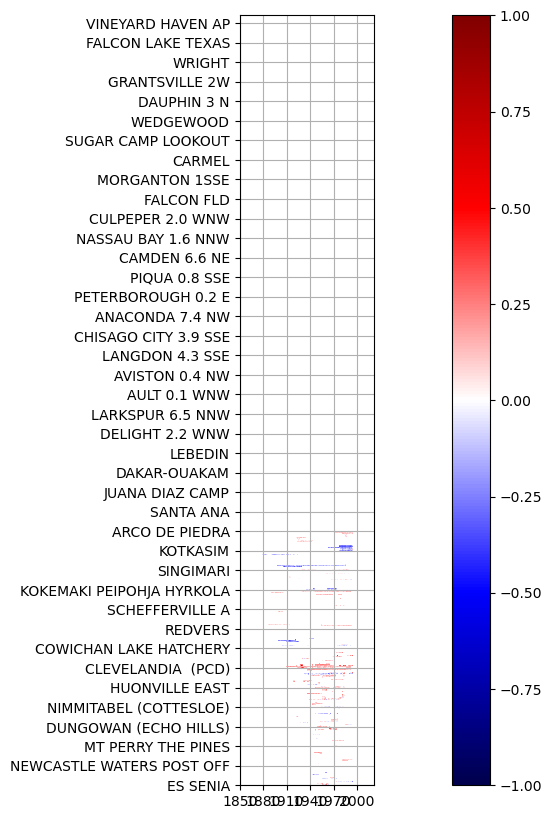

In [11]:
plot_heatmap("PRCP", year_tick_frequency=30, station_tick_frequency=25)

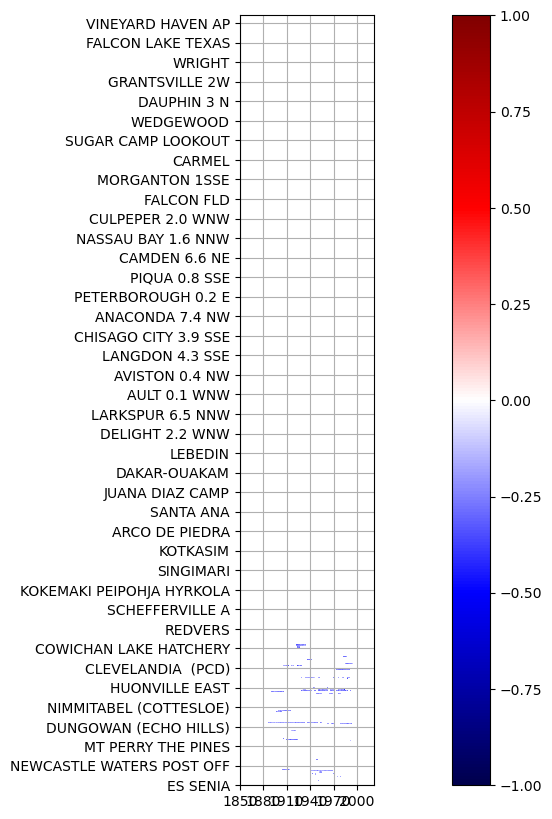

In [12]:
plot_heatmap("SNOW", year_tick_frequency=30, station_tick_frequency=25)